In [1]:
!pip install geocoder
!pip install xlrd
!pip install openpyxl


     |████████████████████████████████| 98 kB 757 kB/s            
     |████████████████████████████████| 96 kB 727 kB/s            
     |████████████████████████████████| 242 kB 624 kB/s            


In [2]:
import pandas as pd 

from sklearn.model_selection import train_test_split 
import re
import geocoder
import numpy as np
import zipfile
import seaborn as sns
import collections
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from bs4 import BeautifulSoup as bs
from sklearn.preprocessing import OrdinalEncoder
from copy import deepcopy

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import torch

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will 
# list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that 
# gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be 
# saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# Объявление вспомогательных функций.  
def info_data(data,raw):
    """ Вывод информации о столбцах, пропусках
        и дубликатах DF.
    
    Args: 
        data: входной DataFrame
        
    Returns:
        str: пробел   
    """
    display(data.head(raw), data.shape)
    df = data.isnull().sum().values
    dd = data.duplicated().sum()
    print(f"\nДатафрейм имеет:\nпризнаков: {len(df)}\nдубликатов: {dd}\n")
    for i in range(len(df)):
        if df[i] != 0:
            di = data.count().index[i]
            print(f"Признак {di} имеет {str(df[i])} пропусков")
    if df.sum() == 0:
        print('Пропусков нет.')

    return print('')

def info_colum(data, idx, *args):
    """ Вывод строки или заданных
        признаков DF.
    
    Args: 
        data:  входной DataFrame
        idx:   индекс строки (int)
        *args: столбцы (str)
        
    Returns:
        str: пробел   
    """
    print('---------------------------')
    print('Index:', idx)
    if type(idx) != str:
        print(data.iloc[idx])
    for ar in args:
        res = data[ar]
        print(f'{ar}   (type: {res.dtype})\n\
    {res[int(idx)]}')
        
    return print('')

In [4]:
# Фиксация RANDOM_SEED.  
RANDOM_SEED = 42

# Фиксация версии пакетов.  
!pip freeze > requirements.txt

# Загрузка данных соревнования.  
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') 
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') 

In [5]:
# Информация о df_train
info_data(df_train, 2)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

(386803, 17)


Датафрейм имеет:
признаков: 17
дубликатов: 307

Признак lat имеет 2448 пропусков
Признак lng имеет 2448 пропусков



In [6]:
# Информация о df_test
info_data(df_test, 2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443

(128935, 16)


Датафрейм имеет:
признаков: 16
дубликатов: 29

Признак lat имеет 820 пропусков
Признак lng имеет 820 пропусков



In [7]:
# Удаление дубликатов.  
df_train.drop_duplicates(inplace=True,ignore_index=True)

df_train['id'] = df_train.index
df_test['id'] = df_test.index

# ВАЖНО! 
# Для корректной обработки признаков объединяем трейн и тест в один датасет.  
# Трейн помечаем 1, тест помечаем 0, reviewer_score ─ нулями.  
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

# Объединение DF.  
hotels = df_test.append(df_train, sort=False).reset_index(drop=True)


<font color='green'>  
  
# **Очистка и анализ данных** </font>

In [8]:
# Информация о датасете.  
info_data(hotels,5)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   
3  Piazza Della Repubblica 17 Central Station 201...   
4  Singel 303 309 Amsterdam City Center 1012 WJ A...   

   additional_number_of_scoring review_date  average_score  \
0                           904   7/21/2017            8.1   
1                           612  12/12/2016            8.6   
2                            46  11/26/2015            8.3   
3                           241  10/17/2015            9.1   
4                           834   5/16/2016            9.1   

                                   hotel_name        reviewer_nationality  \
0                              Hotel Da Vinci             United Kingdom    
1                           Urban Lodge Hotel                    Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton                     Sweden    
3                    Hotel Principe Di Savoia   United States of America    
4                              Hotel Esther a             United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   
4                                        No Negative   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   
3                                  0                     1543   
4                                  0                     4687   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...           656 day   
4  [' Business trip ', ' Solo traveler ', ' Class...           444 day   

         lat       lng  id  sample  reviewer_score  
0  45.533137  9.171102   0       0             0.0  
1  52.385649  4.834443   1       0             0.0  
2  41.393192  2.161520   2       0             0.0  
3  45.479888  9.196298   3       0             0.0  
4  52.370545  4.888644   4       0             0.0

(515431, 19)


Датафрейм имеет:
признаков: 19
дубликатов: 0

Признак lat имеет 3268 пропусков
Признак lng имеет 3268 пропусков



Проверю признак с наименованиями отелей. Возможно, что есть некорректные названия.  
Создам список названий в которых присутствует одна буква.  

In [9]:
# Создание списка названий отелей.  
df_name = hotels['hotel_name'].tolist()

# Создание списка названий отелей с одной буквой.  
one_list, c = [], 0
#idx = []
for i in range(len(df_name)):
    x = list(df_name[i].split())
    for j in range(len(x)):
        if len(x[j]) == 1 and x[j].isdecimal() == False:
            n = df_name[i]
            one_list.append(n)
            #idx.append(i)

# Вывод 20-ти строк списка
while c<20: print(f'{c}:\t{one_list[c]}'); c=c+1
print('Размер списка названий:',len(one_list))

0:	Alexandra Barcelona A DoubleTree by Hilton
1:	Hotel Esther a
2:	Hotel V Nesplein
3:	Hazlitt s
4:	St Martins Lane A Morgans Original
5:	Hotel K nig von Ungarn
6:	Ayre Hotel Gran V a
7:	Ayre Hotel Gran V a
8:	Mill sime H tel
9:	St James Court A Taj Hotel London
10:	M by Montcalm Shoreditch London Tech City
11:	Hotel Casa Fuster G L Monumento
12:	Hotel Casa Fuster G L Monumento
13:	K K H tel Cayr Saint Germain des Pr s
14:	K K H tel Cayr Saint Germain des Pr s
15:	K K H tel Cayr Saint Germain des Pr s
16:	K K H tel Cayr Saint Germain des Pr s
17:	Hotel K nig von Ungarn
18:	Holiday Inn Paris Gare de l Est
19:	Hotel Casa Fuster G L Monumento
Размер списка названий: 60476


Опасения были не напрасными, так как видно, что в названиях отелей отсутствует буква, а то и две.  
Например, строка 13.    
Название:  
"*K K H tel Cayr Saint Germain des Pr s*".  
А на самом деле это:  
"*K+K Hotel Cayre Saint Germain des Pres*".  
Принимаю это к сведению.  

### Географические координаты (признаки lat и lng)
Просмотр пропусков показал, что они имеются в количестве 3268 в географических координатах.  
Причём, обращает внимание на себя тот факт, что пустых данных в координатах одинаковое количество по долготе и широте.  
Не связано ли это с ошибками в других признаках? Вывожу на экран DF с пустыми значениями координат, создаю список уникальных адресов из этого DF.  
Теперь проверю географические координаты: широту и долготу.  
Создам DF из пустых значений координат и посмотрю, что там творится.  

In [10]:
# Информация о пропусках в координатах  
print('None lat:', hotels['lat'].isnull().sum(),'\n'\
'None lng:', hotels['lng'].isnull().sum(),'\n')

# Создание DataFrame c признами широты и долготы у которых NaN.  
df_none = hotels[(hotels['lat'].isnull() | hotels['lng'].isnull())]
display(df_none.head(3), df_none.shape)

# Создание списка уникальных адресов с координатами NaN.  
address_nan_uniq = df_none['hotel_address'].unique().tolist()
display(address_nan_uniq)

None lat: 3268 
None lng: 3268 



hotel_address  \
35   W hringer Stra e 33 35 09 Alsergrund 1090 Vien...   
293  W hringer Stra e 33 35 09 Alsergrund 1090 Vien...   
476  Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...   

     additional_number_of_scoring review_date  average_score  \
35                            214  10/13/2016            7.8   
293                           214   8/20/2015            7.8   
476                            44    5/1/2017            8.0   

                    hotel_name reviewer_nationality  \
35               Hotel Atlanta           Australia    
293              Hotel Atlanta              Sweden    
476  City Hotel Deutschmeister              Taiwan    

                                       negative_review  \
35    The reception staff are somewhat dour and cou...   
293   It is an old hotel with old furniture The roo...   
476                                  WIFI is low speed   

     review_total_negative_word_counts  total_number_of_reviews  \
35                                  21                     2724   
293                                 26                     2724   
476                                  5                      675   

                                       positive_review  \
35    The hotel is pretty from the outside and quai...   
293                         The price and the service    
476         Good room good breakfast and good service    

     review_total_positive_word_counts  \
35                                  60   
293                                  7   
476                                  9   

     total_number_of_reviews_reviewer_has_given  \
35                                           64   
293                                          17   
476                                           1   

                                                  tags days_since_review  lat  \
35   [' Leisure trip ', ' Couple ', ' Double or Twi...           294 day  NaN   
293  [' Leisure trip ', ' Family with older childre...           714 day  NaN   
476  [' Leisure trip ', ' Group ', ' Single Room ',...           94 days  NaN   

     lng   id  sample  reviewer_score  
35   NaN   35       0             0.0  
293  NaN  293       0             0.0  
476  NaN  476       0             0.0

(3268, 19)

['W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 '20 Rue De La Ga t 14th arr 75014 Paris France',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain']

Видно, что адреса занесены с ошибками и <ins>именно по этим адресам отсутствуют географические координаты</ins>. Уникальных значений всего 17.  
Это значит, что надо узнать всего 17 географических координат отелей с испорченными адресами.   
Исправил все адреса и выяснил координаты отелей.   
Всего же надо поправить 3268 записей.

Теперь необходимо откорректировать все обнаруженные на данный момент битые значения.  
Материал очень большой: по названиям отелей надо поправить 60476 значений, по координатам ─ 6536 значений.  
Также надо исправить 3268 записей в адресах отелей. На kaggle это сделать невозможно.  
Исправление только адресов заняло на kaggle более получаса, на домашнем компьютере ─ около 11 минут.  
Датасеты на kaggle размещать и считывать научился, да вот только из шаблона ноутбука соревнования не хочет считывать.  
Промежуточные, вспомогательные DF получаются большими, более 60 МБ и гитхаб не разрешает их грузить.  
Вышел из положения с помощью zip. Исправил все вышеперечисленные ошибки в записях, создал корректный датасет с  
признакми hotel_address, hotel_name, lat, lng, зазиповал и загрузил на гитхаб.  
Теперь здесь корректировать ничего не нужно, иначе заняло бы полдня.  
Загружаю DF с гитхаба с откорректированными по большей части данными.  

In [11]:
# DF до корректировки.  
info_data(hotels, 3)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   

   additional_number_of_scoring review_date  average_score  \
0                           904   7/21/2017            8.1   
1                           612  12/12/2016            8.6   
2                            46  11/26/2015            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   

         lat       lng  id  sample  reviewer_score  
0  45.533137  9.171102   0       0             0.0  
1  52.385649  4.834443   1       0             0.0  
2  41.393192  2.161520   2       0             0.0

(515431, 19)


Датафрейм имеет:
признаков: 19
дубликатов: 0

Признак lat имеет 3268 пропусков
Признак lng имеет 3268 пропусков



In [12]:
# Загрузка DF с исправленными данными по hotel_address, hotel_name, lng, lat.  
url = 'https://github.com/Serg-NSD/sf_data_science/blob/main/project_0.1/hot_geo2.zip?raw=true'
df = pd.read_csv(url, compression='zip', header=0, sep=',')
info_data(df,5)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   
3  Piazza Della Repubblica 17 Central Station 201...   
4  Singel 303 309 Amsterdam City Center 1012 WJ A...   

                                   hotel_name        lat       lng  
0                              Hotel Da Vinci  45.533137  9.171102  
1                           Urban Lodge Hotel  52.385649  4.834443  
2  Alexandra Barcelona A DoubleTree by Hilton  41.393192  2.161520  
3                    Hotel Principe Di Savoia  45.479888  9.196298  
4                              Hotel Estherea  52.370545  4.888644

(515431, 4)


Датафрейм имеет:
признаков: 4
дубликатов: 513937

Пропусков нет.



In [13]:
# Создаю соответствующие списки.  
lst_address = df['hotel_address'].tolist()
lst_name = df['hotel_name'].tolist()
lst_lat = df['lat'].tolist()
lst_lng = df['lng'].tolist()

# Корректировка DF
hotels['hotel_address'] = lst_address
hotels['hotel_name'] = lst_name
hotels['lat'] = lst_lat
hotels['lng'] = lst_lng

In [14]:
# DF после корректировки.  
info_data(hotels, 3)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   

   additional_number_of_scoring review_date  average_score  \
0                           904   7/21/2017            8.1   
1                           612  12/12/2016            8.6   
2                            46  11/26/2015            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   

         lat       lng  id  sample  reviewer_score  
0  45.533137  9.171102   0       0             0.0  
1  52.385649  4.834443   1       0             0.0  
2  41.393192  2.161520   2       0             0.0

(515431, 19)


Датафрейм имеет:
признаков: 19
дубликатов: 0

Пропусков нет.



# **Индекс Джини**

Анализируя ноутбуки участников соревнования я нашёл действия с индексом Джини.  
Логично предположить, что эти значения будут иметь положительное значение для построения модели.  
Поэтому решил тоже воспользоватся этим индексом.  

In [15]:
# Загрузка данных по индексу Джини.  
url = 'https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel'
gdp = pd.read_excel(url, header=3)
display(gdp.head(3))

# Фильтрация и преобразование в словарь.  
cols_to_drop = list(gdp.columns)
cols_to_drop.remove('2020')
gdp.index = gdp['Country Name']
gdp.drop(cols_to_drop,axis=1,inplace=True)
gdp = gdp.to_dict(orient='index')

Country Name Country Code     Indicator Name  \
0                        Aruba          ABW  GDP (current US$)   
1  Africa Eastern and Southern          AFE  GDP (current US$)   
2                  Afghanistan          AFG  GDP (current US$)   

   Indicator Code          1960          1961          1962          1963  \
0  NY.GDP.MKTP.CD           NaN           NaN           NaN           NaN   
1  NY.GDP.MKTP.CD  2.008272e+10  2.050945e+10  2.235043e+10  2.675866e+10   
2  NY.GDP.MKTP.CD  5.377778e+08  5.488889e+08  5.466667e+08  7.511112e+08   

           1964          1965  ...          2012          2013          2014  \
0           NaN           NaN  ...  2.534637e+09  2.727850e+09  2.790849e+09   
1  2.446499e+10  2.787894e+10  ...  9.505214e+11  9.642424e+11  9.848071e+11   
2  8.000000e+08  1.006667e+09  ...  1.990732e+10  2.014640e+10  2.049713e+10   

           2015          2016          2017          2018          2019  \
0  2.962905e+09  2.983637e+09  3.092430e+09  3.202189e+09           NaN   
1  9.199300e+11  8.733549e+11  9.853557e+11  1.012853e+12  1.009910e+12   
2  1.913421e+10  1.811656e+10  1.875347e+10  1.805323e+10  1.879945e+10   

           2020  2021  
0           NaN   NaN  
1  9.207923e+11   NaN  
2  2.011614e+10   NaN  

[3 rows x 66 columns]

In [16]:
# Данные об индексе Джини и населению стран.  
url = 'https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country'
page = requests.get(url)
soup = bs(page.content, 'html.parser')
tbl = soup.find("table")
gini_index = pd.read_html(str(tbl))[0]
display(gini_index.head(3))
#gini_index.to_csv('data/gini_idx.csv', sep=',', index=False)

# Фильтрация и преобразование в словарь.  
gini_index.index = gini_index['Country']
gini_index.drop(['Country','Data Year (World Bank)',\
    'Gini % - CIA World Factbook','Data Year (CIA)'],axis=1,inplace=True)
gini_index = gini_index.to_dict(orient='index')

Country  Gini % - World Bank  Data Year (World Bank)  \
0  South Africa                 63.0                  2014.0   
1       Namibia                 59.1                  2015.0   
2      Suriname                 57.9                  1999.0   

   Gini % - CIA World Factbook  Data Year (CIA)  2022 Population  
0                         63.0           2014.0         60756135  
1                         59.1           2015.0          2633874  
2                          NaN              NaN           596831

<font color='green'>

# **Адреса отелей (признак hotel_address)**</font>
Провожу выборку стран, почтовых индексов и городов из адресов ателей.  
Добавляю их в новые признаки.  
При этом надо учитывать, что названия некоторые стран могут быть из двух и более слов. 

In [17]:
# Из признака reviewer_nationality беру страны с названием из  
# двух и более слов. Составляю список для проверки.  
cont=[]
for i in range(len(hotels)):
    lst = hotels['reviewer_nationality'][i].strip()
    if len(lst.split()) > 1:
        cont.append(lst.lower())

country = sorted(list(set(cont)))
print(country)

# В адресах отелей проверяю наличие стран с названием из двух слов.  
double=[]
for i in range(len(hotels)):
    address = hotels['hotel_address'][i].lower()
    for j in range(len(country)):
        if country[j] in address:
            double.append(country[j])

print('\nНазвание государства из двух букв:', str(*set(double)).title())

['abkhazia georgia', 'american samoa', 'antigua barbuda', 'bonaire st eustatius and saba', 'bosnia and herzegovina', 'british virgin islands', 'cape verde', 'cayman islands', 'central africa republic', 'cocos k i', 'cook islands', 'costa rica', 'cura ao', 'czech republic', 'democratic republic of the congo', 'dominican republic', 'east timor', 'el salvador', 'equatorial guinea', 'falkland islands malvinas', 'faroe islands', 'french guiana', 'french polynesia', 'hong kong', 'isle of man', 'ivory coast', 'new caledonia', 'new zealand', 'northern mariana islands', 'palestinian territory', 'papua new guinea', 'puerto rico', 'saint barts', 'saint kitts and nevis', 'saint lucia', 'saint martin', 'saint vincent grenadines', 'san marino', 'saudi arabia', 'sierra leone', 'south africa', 'south korea', 'south sudan', 'sri lanka', 'st maarten', 'st pierre and miquelon', 'svalbard jan mayen', 'trinidad and tobago', 'turks caicos islands', 'u s virgin islands', 'united arab emirates', 'united kingd

В признаке hotel_address имеется только одно государство с названием из двух букв.  
Это ─ United Kingdom. Его и буду учитывать при выборке стран и городов.

In [18]:
# Выборка названий стран, городов и почтовых индексов. 
# Запись данных в новые признаки.  
hotels['zip'] = [x.split()[-4]+' '+x.split()[-3] if x.split()[-1]=='Kingdom' \
    or x.split()[-1]=='Netherlands' else x.split()[-3] for x in hotels['hotel_address']]
hotels['country'] = ['United Kingdom' if x.split()[-1]=='Kingdom' else \
    x.split()[-1] for x in hotels['hotel_address']]
hotels['city'] = ['London' if x.split()[-2]=='United' else \
    x.split()[-2] for x in hotels['hotel_address']]

display(hotels.head(2))
print(len(hotels['city']), len(hotels['country']), len(hotels['zip']))
print(hotels['city'].isnull().sum(), hotels['country'].isnull().sum(), \
    hotels['zip'].isnull().sum())

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  ...  \
0   Hotel was great clean friendly staff free bre...  ...   
1                                        No Positive  ...   

                                                tags  days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...            13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...            234 day   

         lat       lng  id  sample  reviewer_score      zip      country  \
0  45.533137  9.171102   0       0             0.0    20161        Italy   
1  52.385649  4.834443   1       0             0.0  1043 EW  Netherlands   

        city  
0      Milan  
1  Amsterdam  

[2 rows x 22 columns]

515431 515431 515431
0 0 0


Столбцы city, country и zip заполнены полностью, пропусков в них нет.  
Далее определяю уникальные названия стран и городов.

In [19]:
# Уникальные названия городов и стран соответственно.  
print(list(hotels['country'].unique()))
print(list(hotels['city'].unique()))

['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France', 'Austria']
['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']


In [20]:
# Получим данные из закаченных источников по индексу Джини, 
# популяции и ВВП для стран с отелем.  
hotels['hc_gini'] = hotels['country'].apply(lambda x: gini_index[x] \
    ['Gini % - World Bank'])
hotels['hc_population'] = hotels['country'].apply(lambda x: gini_index[x] \
    ['2022 Population'])
hotels['hc_gdp'] = hotels['country'].apply(lambda x: gdp.get(x)['2020'] \
    if gdp.get(x) is not None else 0)

In [21]:
# Создаю словари с популяцией городов и стран.  
city_pop = {
    'Milan': 1296673, 
    'Amsterdam': 1027860,
    'Barcelona': 1593075, 'London': 8308369,
    'Paris': 2257981, 'Vienna': 1664146}

# Создаю признаки count_pop, city_pop и percent_ratio.  
hotels['city_pop'] = hotels['city'].map(city_pop)

# Отношение числа жителей города к числу жителей этой страны.  
hotels['popul_perc_ratio'] = 100*hotels['city_pop'] / hotels['hc_population']

# Признак hotel_address более не понадобится. Удаляю его.  
hotels.drop('hotel_address', axis=1, inplace=True)
hotels.reset_index(drop=True, inplace=True)

In [22]:
info_data(hotels, 2)
hotels.info()

additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  ...  sample reviewer_score      zip  \
0                                 62  ...       0            0.0    20161   
1                                  0  ...       0            0.0  1043 EW   

       country       city  hc_gini  hc_population        hc_gdp city_pop  \
0        Italy      Milan     35.9       60262770  1.888709e+12  1296673   
1  Netherlands  Amsterdam     28.1       17211447  9.138654e+11  1027860   

  popul_perc_ratio  
0         2.151698  
1         5.971956  

[2 rows x 26 columns]

(515431, 26)


Датафрейм имеет:
признаков: 26
дубликатов: 0

Пропусков нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   review_date                                 515431 non-null  object 
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_

<font color='green'>  
  
# **Визуализация** </font>

In [23]:
hot_vis = deepcopy(hotels)

# Подготовка DF для визуализации.  
new = hot_vis[['country', 'city', 'review_date', 'hotel_name']].copy()
new['review_date'] = pd.to_datetime(new['review_date'])
new['review_date'] = new['review_date'].astype('str')
df = new.groupby(by=['country', 'review_date'], as_index=False) \
    ['hotel_name'].count()
df.reset_index(drop=True, inplace=True)
df

country review_date  hotel_name
0            Austria  2015-08-04          86
1            Austria  2015-08-05          46
2            Austria  2015-08-06          70
3            Austria  2015-08-07          38
4            Austria  2015-08-08          50
...              ...         ...         ...
4381  United Kingdom  2017-07-30         120
4382  United Kingdom  2017-07-31         110
4383  United Kingdom  2017-08-01         114
4384  United Kingdom  2017-08-02        2112
4385  United Kingdom  2017-08-03         491

[4386 rows x 3 columns]

In [24]:
# Вспомогательная функция переименования.  
def rename(data):
    return data.rename(
        columns={'country':'Страна', 'city': 'Город',
                 'hotel_name':'Количество', 'review_date': 'Дата'})

# Определение списков городов и стран. 
city =['<b>Вена</b>','<b>Париж</b>','<b>Милан</b>',\
    '<b>Амстердам</b>','<b>Барселона</b>','<b>Лондон</b>']
coun =['<b>Австрия</b>','<b>Франция</b>','<b>Италия</b>',\
    '<b>Нидерланды</b>','<b>Испания</b>','<b>Великобритания</b>']

# Подготовка DF для столбчатой диаграммы.  
df_fig1 = hotels.groupby(
    by=['country', 'city'], as_index=False)['reviewer_nationality'].count()
df_fig1 = df_fig1.rename(columns={
        'country':'Страна','city':'Город','reviewer_nationality':'Количество'})
df_fig1['Город'] = city; df_fig1['Страна'] = coun

# Подготовка DF для картограммы.  
df_fig2 = hotels.groupby(
    by=['country','city'], as_index=False)['hotel_name'].nunique()
df_fig2['review_date'] = 0; df_fig2 = rename(df_fig2)
df_fig2['Город'] = city; 

# Подготовка DF для анимационной картограммы.  
df_fig3 = hotels[['country', 'city', 'review_date', 'hotel_name']].copy()
df_fig3['review_date']=pd.to_datetime(df_fig3['review_date']).astype('str')
df_fig3 = df_fig3.groupby(
    by=['country', 'review_date'], as_index=False)['hotel_name'].count()
df_fig3 = rename(df_fig3)

In [25]:
# Устанавка параметров метода update_layout для plotly.express.bar.  
titls = {
    'x':0.5,
    'text':'<b>Количество постояльцев отелей в зависимости от \
стран (за два года)</b>',
    'font':{'size': 17, 'color':'blue','family':'Arial'}}
xaxis_titl = {
    'text': '<b>Страны Европы</b>',
    'font':{'size': 16, 'color':'darkred', 'family':'Arial'}}
yaxis_titl = {
    'text': "<br></br><b>Количество клиентов <i>(чел.)</i></b><br></br>",
    'font':{'size': 16, 'color':'darkred', 'family':'Arial'}}
legend_titl = {
    'text':'<b>           Города:</b>',
    'font':{'size':12.5, 'color': 'darkblue'}}
lgd = {'x':1, 'y': 1, 'font':{'size':12, 'color': 'darkred'}}

# Построение столбчатой диаграммы, вывод на экран.  
fig1 = px.bar(
    data_frame=df_fig1,
    x='Страна',
    y='Количество',
    color='Город',
    color_discrete_sequence=['#B807BE', '#00CEC7', 'red', 'darkgreen', \
                             'yellow', 'blue'],
    width=680,
    height=650,
    ).update_layout(
        title=titls, legend=lgd, legend_title=legend_titl,
        xaxis_title=xaxis_titl, yaxis_title=yaxis_titl
        );
fig1.show()

# Построение картограммы, вывод на экран.  
fig2 = px.choropleth(df_fig2,
    title=\
      '<b>Распределение количества отелей в зависимости от стран Европы</b>',
    locations='Страна',
    locationmode = "country names",
    scope='europe',
    color='Количество',
    color_continuous_scale='Rainbow',
    width=680,
    height=650);
fig2.show()

# Построение анимационной картограммы, вывод на экран.  
fig3 = px.choropleth(df_fig3, locations="Страна",
    color="Количество",
    hover_name="Страна",
    hover_data = ["Количество"],
    locationmode = "country names",
    animation_frame="Дата",
    color_continuous_scale=px.colors.sequential.Rainbow,
    scope ='europe',
    width=680, height=650);
fig3.update_layout(
    title_text = '<b>Количество клиентов по датам в зависимости от страны</b>',
    title_x = 0.5, geo=dict(showframe = False, showcoastlines = False,));
fig3.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 230
fig3.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 150
fig3.show(renderer='notebook')

<font color='green'>

# **Дата (признак review_date)**</font>
Приведём признак к типу datetime. 
Затем выделим из него года, месяцы, дни и недели в четыре новых признака: year, month, day и dayofweek.

In [26]:
hot_date = deepcopy(hotels)

# Преобразование к типу datetime.
hot_date['review_date']=pd.to_datetime(hot_date['review_date'])
info_colum(hot_date, '33', 'review_date')

# Добавление признаков.  
hotels['day'] = hot_date['review_date'].dt.day
hotels['month'] = hot_date['review_date'].dt.month
hotels['year'] = hot_date['review_date'].dt.year
hotels['dayofweek'] = hot_date['review_date'].dt.dayofweek

# Признак review_date больше не нужен. Удаляю его.  
hotels.drop(columns=['review_date'], axis=1, inplace=True)
info_data(hotels, 3)
info_colum(hotels, '2', 'day', 'month', 'year', 'dayofweek')

---------------------------
Index: 33
review_date   (type: datetime64[ns])
    2017-01-01 00:00:00



additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  ...       city hc_gini  \
0                                           1  ...      Milan    35.9   
1                                           7  ...  Amsterdam    28.1   
2                                          15  ...  Barcelona    34.7   

   hc_population        hc_gdp  city_pop  popul_perc_ratio  day month  year  \
0       60262770  1.888709e+12   1296673          2.151698   21     7  2017   
1       17211447  9.138654e+11   1027860          5.971956   12    12  2016   
2       46719142  1.281485e+12   1593075          3.409898   26    11  2015   

  dayofweek  
0         4  
1         0  
2         3  

[3 rows x 29 columns]

(515431, 29)


Датафрейм имеет:
признаков: 29
дубликатов: 0

Пропусков нет.

---------------------------
Index: 2
day   (type: int64)
    26
month   (type: int64)
    11
year   (type: int64)
    2015
dayofweek   (type: int64)
    3



<font color='green'>  
  
## **Работа с признаками *negative_review* и *positive_review*.**
</font>

In [27]:
# Проверяю отзывы на цифры. Где нет слов, только числа.
lst_review = []
for i in hotels.index:
    x_neg = hotels['negative_review'][i].strip().replace(' ', '')
    x_pos = hotels['positive_review'][i].strip().replace(' ', '')
    if x_neg.isdecimal():
        lst_review.append(i)
    if x_pos.isdecimal():
        lst_review.append(i)
        
print('Индексы строк, где в отзывах только числа:\n',lst_review)

Индексы строк, где в отзывах только числа:
 [14941, 22455, 22455, 43611, 78986, 101110, 126330, 139010, 140774, 155017, 178878, 187619, 205155, 219188, 220037, 261714, 283073, 325282, 384703, 396718, 410871, 426557, 501977]


In [29]:
%%time
# Списки с негативными и позитивными выражениями.  
negative = ['no positive', 'nothing']
positive = ['nothing', 'no negative', 'n a', 'none', '', 'all good', \
            'nothing really', 'no complaints', 'nil', 'nothing at all', \
            'na', 'nothing to dislike', 'liked everything', \
            'can t think of anything', 'everything was perfect', 'no', \
            'absolutely nothing', 'nothing to dislike', 'everything was great', \
            'nothing to complain about', 'non', 'everything']

# Замена отзывов в признаках, содержащих выражения в списках на однозначные.  
hotels.loc[hotels['negative_review'].str.lower().str.strip().isin(positive), \
        'negative_review'] = 'Positive'
hotels.loc[hotels['positive_review'].str.lower().str.strip().isin(negative), \
        'positive_review'] = 'Negative'

# Корректирую, после анализа, отзывы, где проставлены числа.   
# Удалять нельзя, т.к. изменится sample=0.  
change_neg = [14941, 22455, 126330, 187619, 205155, 325282]
change_pos = [43611, 78986, 101110, 139010, 140774, 155017, 178878, 219188, \
              220037, 261714, 283073, 384703, 396718, 410871, 426557, 501977]

for i in change_neg:
    hotels.iloc[i, 4] = 'Negative'
    hotels.iloc[i, 7] = '0'

for j in change_pos:
    hotels.iloc[j, 4] = '0'
    hotels.iloc[j, 7] = 'Positive'


sia = SentimentIntensityAnalyzer()

# Анализ отзывов.  
hotels.loc[:,['neg_sentenc_rev']] = hotels['negative_review'].\
    apply(lambda x: sia.polarity_scores(x))
hotels.loc[:,['pos_sentenc_rev']] = hotels['positive_review'].\
    apply(lambda x: sia.polarity_scores(x))

# Запись результатов.  
hotels.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = \
list(hotels['neg_sentenc_rev'].apply(lambda x: [x['neg'], x['neu'], x['pos'], \
                                             x['compound']]).values)
hotels.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = \
list(hotels['pos_sentenc_rev'].apply(lambda x: [x['neg'], x['neu'], x['pos'], \
                                             x['compound']]).values)

# Удаление вспомогательных столбцов.  
hotels.drop(columns=['neg_sentenc_rev', 'pos_sentenc_rev'], inplace=True)
hotels.reset_index(drop=True, inplace=True)

CPU times: user 4min 39s, sys: 3.57 s, total: 4min 43s
Wall time: 4min 43s


In [30]:
info_data(hotels, 3)

additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                           Negative   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  ...  year dayofweek  n_neg  \
0                                           1  ...  2017         4  0.129   
1                                           7  ...  2016         0  0.216   
2                                          15  ...  2015         3  0.000   

   n_neu  n_pos  n_compound  p_neg  p_neu  p_pos p_compound  
0  0.747  0.125     -0.0554    0.0  0.671  0.329     0.9615  
1  0.784  0.000     -0.2960    1.0  0.000  0.000    -0.5719  
2  1.000  0.000      0.0000    0.0  0.260  0.740     0.6908  

[3 rows x 37 columns]

(515431, 37)


Датафрейм имеет:
признаков: 37
дубликатов: 0

Пропусков нет.



In [31]:
# Функция создания списка слов.  
def df_unity(data):
    l=[]
    for i in data.index:
        for j in data[i]:
          if j in del_list:
              continue
          l.append(j)
    return l

# Определение списка слов для их удаления.  
del_list=['was', 'staff', 'with', 'wifi', 'wi-fi', 'connection', 'sized',\
          'the', 'fact', 'that', 'a', 'to', 'and', 'in', 'isn', 't', 'is',\
          'i', 'of', 'you', 'for', 'it']

# Добавление в DF списков из слов-отзывов
hotels['pos_rev_words'] = [''.join(x).strip().lower().split() for x in \
                        hotels['positive_review']]
hotels['neg_rev_words'] = [''.join(x).strip().lower().split() for x in \
                        hotels['negative_review']]

# Очистка и создание списков слов pos_list и neg_list.  
pos_list = df_unity(hotels['pos_rev_words'])
neg_list = df_unity(hotels['neg_rev_words'])

# Подсчёт количества уникальных слов.  
pos_words = collections.Counter(pos_list)
neg_words = collections.Counter(neg_list)

# Топ из пяти часто повторяющихся слов
top_pos = set([key for key, _ in pos_words.most_common(5)])
top_neg = set([key for key, _ in neg_words.most_common(5)])

# Заполнение DF данными пересечения множества со списком top_pos.  
hotels['pos_rev_words'] = hotels['pos_rev_words'].apply(lambda x: '|'. \
        join(sorted(list(top_pos.intersection(set(x))))))
hotels['neg_rev_words'] = hotels['neg_rev_words'].apply(lambda x: '|'. \
        join(sorted(list(top_neg.intersection(set(x))))))

# Соотношением количества позитивных и негативных слов.  
hotels['pos_words_percent'] = 100 * hotels['review_total_positive_word_counts'] / \
    (hotels['review_total_negative_word_counts'] + \
     hotels['review_total_positive_word_counts'])
hotels['neg_words_percent'] = 100 * hotels['review_total_negative_word_counts'] / \
    (hotels['review_total_negative_word_counts'] + \
     hotels['review_total_positive_word_counts'])

# Отношение количества отзывов, данных клиентами в прошлом.  
hotels['after_pos_words'] = hotels['review_total_positive_word_counts'] / \
    hotels['total_number_of_reviews_reviewer_has_given']
hotels['after_neg_words'] = hotels['review_total_negative_word_counts'] / \
    hotels['total_number_of_reviews_reviewer_has_given']

# Оценка позитивных и негативных комментариев.  
hotels['pos_rate'] = hotels['review_total_positive_word_counts'] / \
    hotels['total_number_of_reviews']
hotels['neg_rate'] = hotels['review_total_negative_word_counts'] / \
    hotels['total_number_of_reviews']

# Отношение негатива/позитива к гостям и действительным отзывам.  
hotels['add_pos_rate'] = hotels['review_total_positive_word_counts'] / \
    hotels['additional_number_of_scoring']
hotels['add_neg_rate'] = hotels['review_total_negative_word_counts'] / \
    hotels['total_number_of_reviews']

# Рейтинг отзыва.  
hotels['rev_rate'] = hotels['total_number_of_reviews_reviewer_has_given'] / \
    hotels['total_number_of_reviews']

In [32]:
info_data(hotels, 3)

additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                           Negative   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  ... neg_rev_words  \
0                                           1  ...           not   
1                                           7  ...          room   
2                                          15  ...                 

  pos_words_percent  neg_words_percent  after_pos_words  after_neg_words  \
0         54.385965          45.614035        62.000000        52.000000   
1          0.000000         100.000000         0.000000         1.428571   
2         62.500000          37.500000         0.333333         0.200000   

   pos_rate  neg_rate add_pos_rate add_neg_rate  rev_rate  
0  0.003719  0.003119     0.068584     0.003119  0.000060  
1  0.000000  0.001993     0.000000     0.001993  0.001395  
2  0.014245  0.008547     0.108696     0.008547  0.042735  

[3 rows x 48 columns]

(515431, 48)


Датафрейм имеет:
признаков: 48
дубликатов: 0

Признак pos_words_percent имеет 127 пропусков
Признак neg_words_percent имеет 127 пропусков



## Подготовка и тренировка модели

In [33]:
# Так как появились пропуски, то заполню их медианой.
hotels['pos_words_percent'].fillna(hotels['pos_words_percent'].median(), inplace=True)
hotels['neg_words_percent'].fillna(hotels['pos_words_percent'].median(), inplace=True)

In [34]:
info_data(hotels, 3)

additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci      United Kingdom    
1                           Urban Lodge Hotel             Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton              Sweden    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                           Negative   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  ... neg_rev_words  \
0                                           1  ...           not   
1                                           7  ...          room   
2                                          15  ...                 

  pos_words_percent  neg_words_percent  after_pos_words  after_neg_words  \
0         54.385965          45.614035        62.000000        52.000000   
1          0.000000         100.000000         0.000000         1.428571   
2         62.500000          37.500000         0.333333         0.200000   

   pos_rate  neg_rate add_pos_rate add_neg_rate  rev_rate  
0  0.003719  0.003119     0.068584     0.003119  0.000060  
1  0.000000  0.001993     0.000000     0.001993  0.001395  
2  0.014245  0.008547     0.108696     0.008547  0.042735  

[3 rows x 48 columns]

(515431, 48)


Датафрейм имеет:
признаков: 48
дубликатов: 0

Пропусков нет.



<font color='green'>  

## **Признак *reviewer_nationality*.**
</font>

In [35]:
# Очистка review_nationality от возможных пробелов.  
display(hotels['reviewer_nationality'][0])
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(\
    lambda x: x.strip())
display(hotels['reviewer_nationality'][0])

' United Kingdom '

'United Kingdom'

Так как в США много штатов, то логично допустить, что клиенты писали только название штата или сокращённое название США.  
Проверю этот признак на данное предположение, а также название United States of America заменю на United States.  
Помимо этого проверю этот признак на правильность названий.  

In [36]:
# Создаю список из штатов и их возможные варианты написания.  
states_list = ["Jersey","Idaho", "Iowa", "Alabama", "Alaska", "Arizona", \
    "Arkansas", "Wyoming", "Washington", "Vermont", "Virginia", "Wisconsin",\
    "Hawai`i", "Hawai'i" , "Delaware", "Georgia", "West Virginia", "Illinois",\
    "Indiana", "California", "Kansas", "Kentucky", "Colorado", "Connecticut",\
    "Louisiana", "Massachusetts", "Minnesota", "Mississippi", "Missouri",\
    "Michigan", "Montana", "Maine", "Maryland", "Nebraska", "Nevada", \
    "Hampshire", "New York", "New Mexico", "Ohio", "Oklahoma", "Oregon", \
    "Pennsylvania", "Rhode Island and Providence Plantations", "Rhode", \
    "Providence", "Dakota", "Carolina", "Tennessee", "Texas", "Florida", \
    "Utah", "US", "U S", "America", "USA", "U.S.A", "United", "States", \
    "United States of America"]

# Корректирую данные в hotels['reviewer_nationality']
mask = hotels['reviewer_nationality']
hotels['reviewer_nationality'] = mask.apply(lambda x: 'United States' \
    if x in states_list else x)
hotels['reviewer_nationality'] = mask.apply(lambda x: 'Curacao' \
    if x=='Cura ao' else x)
hotels['reviewer_nationality'] = mask.apply(lambda x: 'Australia' \
    if x=='Cocos K I' else x)
hotels['reviewer_nationality'] = mask.apply(lambda x: 'U.S. Virgin Islands' \
    if x=='U S Virgin Islands' else x)


# Данные из источников по индексу Джини, популяции и ВВП для стран ревьюера. 
hotels['rc_gini'] = hotels['reviewer_nationality'].apply(lambda x: \
    gini_index.get(x)['Gini % - World Bank'] if gini_index.get(x) \
    is not None else 0)
hotels['rc_population'] = hotels['reviewer_nationality'].apply(lambda x: \
    gini_index.get(x)['2022 Population'] if gini_index.get(x) \
    is not None else 0)
hotels['rc_gdp'] = hotels['reviewer_nationality'].apply(lambda x: gdp.get(x)['2020'] \
    if gdp.get(x) is not None else 0)

# Дополнительное заполнение индексов Джини медианным значением.  
hotels['rc_gini'].fillna(hotels['rc_gini'].median(),inplace=True)
hotels['rc_gdp'].fillna(hotels['rc_gdp'].median(),inplace=True)

# Подготовка к кодированию.  
rew_nat = hotels['reviewer_nationality'].tolist()

# Подсчёт количества уникальных слов.  
rew_nat_uniq = collections.Counter(rew_nat)

# Топ из пяти часто повторяющихся слов.
top_rew_nat = set([key for key, _ in rew_nat_uniq.most_common(5)])
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x \
    if x in top_rew_nat else 'other')  

rew_zip = hotels['zip'].tolist()
rew_zip_uniq = collections.Counter(rew_zip)
top_rew_zip = set([key for key, _ in rew_zip_uniq.most_common(5)])
hotels['zip'] = hotels['zip'].apply(lambda x: x if x in top_rew_zip else 'other')  

In [37]:
info_data(hotels, 3)

additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci       United Kingdom   
1                           Urban Lodge Hotel                other   
2  Alexandra Barcelona A DoubleTree by Hilton                other   

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                           Negative   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  ... after_pos_words  \
0                                           1  ...       62.000000   
1                                           7  ...        0.000000   
2                                          15  ...        0.333333   

  after_neg_words  pos_rate  neg_rate  add_pos_rate  add_neg_rate  rev_rate  \
0       52.000000  0.003719  0.003119      0.068584      0.003119  0.000060   
1        1.428571  0.000000  0.001993      0.000000      0.001993  0.001395   
2        0.200000  0.014245  0.008547      0.108696      0.008547  0.042735   

  rc_gini rc_population        rc_gdp  
0    35.1      68497907  2.759804e+12  
1    27.2      11668278  5.218613e+11  
2    30.0      10218971  5.412201e+11  

[3 rows x 51 columns]

(515431, 51)


Датафрейм имеет:
признаков: 51
дубликатов: 0

Пропусков нет.



<font color='green'>  

## **Признак *days_since_review*.**
</font>

In [38]:
# Привожу в тип int.  
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: \
    int(x.split()[0]))
hotels['days_since_review'].head(3)

0     13
1    234
2    616
Name: days_since_review, dtype: int64

<font color='green'>  

## **Признак *tags*.**
</font>

In [39]:
# Чистка тегов. 
def clr_t(tag):
    return tag.replace("[' ", '').replace(" ']", '').replace(\
    " '", '').replace(", ", ',').split(',')

def unity(data):
        l=[]
        for i in data.index:
            l.extend(data[i])
        return l

hotels['tags_list'] = hotels['tags'].apply(lambda x: clr_t(x))
tags_count = collections.Counter(unity(hotels['tags_list']))
tags_top = set([key for key, _ in tags_count.most_common(10)])
hotels['tags'] = hotels['tags_list'].apply(lambda x: '|'.join(\
    sorted(list(tags_top.intersection(set(x))))))

# Удаляю вспомогательный столбец.  
hotels.drop(columns=['tags_list'], inplace=True)

In [40]:
info_colum(hotels, '777', 'tags')
info_colum(hotels, '7777', 'tags')
info_data(hotels, 3)

---------------------------
Index: 777
tags   (type: object)
    Family with young children|Leisure trip|Stayed 1 night|Submitted from a mobile device

---------------------------
Index: 7777
tags   (type: object)
    Leisure trip|Solo traveler|Stayed 2 nights



additional_number_of_scoring  average_score  \
0                           904            8.1   
1                           612            8.6   
2                            46            8.3   

                                   hotel_name reviewer_nationality  \
0                              Hotel Da Vinci       United Kingdom   
1                           Urban Lodge Hotel                other   
2  Alexandra Barcelona A DoubleTree by Hilton                other   

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                           Negative   
2                         Nice welcoming and service   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  ... after_pos_words  \
0                                           1  ...       62.000000   
1                                           7  ...        0.000000   
2                                          15  ...        0.333333   

   after_neg_words  pos_rate  neg_rate  add_pos_rate  add_neg_rate  rev_rate  \
0        52.000000  0.003719  0.003119      0.068584      0.003119  0.000060   
1         1.428571  0.000000  0.001993      0.000000      0.001993  0.001395   
2         0.200000  0.014245  0.008547      0.108696      0.008547  0.042735   

  rc_gini rc_population        rc_gdp  
0    35.1      68497907  2.759804e+12  
1    27.2      11668278  5.218613e+11  
2    30.0      10218971  5.412201e+11  

[3 rows x 51 columns]

(515431, 51)


Датафрейм имеет:
признаков: 51
дубликатов: 0

Пропусков нет.



<font color='green'>  

## **Признак *hotel_name*.**
</font>

In [41]:
# Сетевые отели. 
hotels['hotel_net'] = hotels['hotel_name'].apply(
lambda x: re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|\
    Radisson|Best Western|DoubleTree',x)[0] \
    if (re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|\
    Radisson|Best Western|DoubleTree',x) is not None) else 'Not_in_net')

In [42]:
info_data(hotels, 2)

additional_number_of_scoring  average_score         hotel_name  \
0                           904            8.1     Hotel Da Vinci   
1                           612            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0       United Kingdom   Would have appreciated a shop in the hotel th...   
1                other        No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                           Negative   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  ... after_neg_words  pos_rate  \
0                                           1  ...       52.000000  0.003719   
1                                           7  ...        1.428571  0.000000   

   neg_rate  add_pos_rate  add_neg_rate  rev_rate  rc_gini rc_population  \
0  0.003119      0.068584      0.003119  0.000060     35.1      68497907   
1  0.001993      0.000000      0.001993  0.001395     27.2      11668278   

         rc_gdp   hotel_net  
0  2.759804e+12  Not_in_net  
1  5.218613e+11  Not_in_net  

[2 rows x 52 columns]

(515431, 52)


Датафрейм имеет:
признаков: 52
дубликатов: 0

Пропусков нет.



<font color='green'>  

## **Кодировка**
</font>

In [44]:
to_ordenc_list = ['reviewer_nationality','country', 'city', 'zip', \
                  'pos_rev_words','neg_rev_words','tags','hotel_net']
enc = OrdinalEncoder()
enc.fit(hotels[to_ordenc_list])
hotels[to_ordenc_list] = enc.transform(hotels[to_ordenc_list])

hotels['neg_len'] = hotels['negative_review'].map(len)
hotels['pos_len'] = hotels['positive_review'].map(len)
hotels['neg_rev_words']

0          1.0
1         25.0
2          0.0
3         17.0
4         17.0
          ... 
515426    17.0
515427    17.0
515428    25.0
515429    17.0
515430    25.0
Name: neg_rev_words, Length: 515431, dtype: float64

In [45]:
# Удаление обработанных текстовых признаков.
object_columns = [x for x in hotels.columns if hotels[x].dtypes == 'object']
print(object_columns)
hotels.drop(object_columns, axis = 1, inplace=True)

['hotel_name', 'negative_review', 'positive_review']


In [46]:
info_data(hotels, 3)

additional_number_of_scoring  average_score  reviewer_nationality  \
0                           904            8.1                   3.0   
1                           612            8.6                   5.0   
2                            46            8.3                   5.0   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   

   total_number_of_reviews_reviewer_has_given  tags  days_since_review  \
0                                           1  45.0                 13   
1                                           7  75.0                234   
2                                          15  28.0                616   

         lat  ...  neg_rate  add_pos_rate  add_neg_rate  rev_rate  rc_gini  \
0  45.533137  ...  0.003119      0.068584      0.003119  0.000060     35.1   
1  52.385649  ...  0.001993      0.000000      0.001993  0.001395     27.2   
2  41.393192  ...  0.008547      0.108696      0.008547  0.042735     30.0   

   rc_population        rc_gdp  hotel_net  neg_len  pos_len  
0       68497907  2.759804e+12        5.0      262      337  
1       11668278  5.218613e+11        5.0       44        8  
2       10218971  5.412201e+11        1.0        9       27  

[3 rows x 51 columns]

(515431, 51)


Датафрейм имеет:
признаков: 51
дубликатов: 0

Пропусков нет.



<font color='green'>

## **Подготовка данных**</font>

In [47]:
hotels.reset_index(drop=True, inplace=True)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   reviewer_nationality                        515431 non-null  float64
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   tags                                        515431 non-null  float64
 8   days_since_review                           515431 non-null  int64  
 9   lat                                         515431 non-null  float64
 

In [48]:
# Разделение на два DataFrame.
train_data = hotels[hotels['sample'] == 1]
test_data = hotels[hotels['sample'] == 0]

train_data.index = train_data['id']
test_data.index = test_data['id']

train_data.drop(['sample','id'],axis=1,inplace=True)
test_data.drop(['sample','id','reviewer_score'],axis=1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
# числовые признаки
num_cols = [
    'additional_number_of_scoring', 'average_score', \
    'review_total_negative_word_counts',
    'total_number_of_reviews','review_total_positive_word_counts',\
    'total_number_of_reviews_reviewer_has_given','days_since_review', 'lat',\
    'lng', 'hc_gini', 'hc_population', 'hc_gdp', 'rc_gini', 'rc_population',\
    'rc_gdp', 'n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg', 'p_neu',\
    'p_pos', 'p_compound', 'pos_words_percent', 'neg_words_percent', \
    'neg_len', 'pos_len', 'neg_rate', 'pos_rate', 'add_pos_rate', \
    'add_neg_rate', 'after_pos_words', 'after_neg_words','rev_rate']

# Категориальные признаки.  
cat_cols = [
    'reviewer_nationality', 'tags', 'country', 'city', 'popul_perc_ratio',\
    'zip', 'city_pop', 'neg_rev_words', 'pos_rev_words', 'year', 'month',\
    'day', 'dayofweek', 'hotel_net']

In [50]:
# Разделение DF на части для обучения и тестирования модели.  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей).
X = train_data.drop(['reviewer_score'], axis = 1)
y = train_data['reviewer_score'].astype('int')
X.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'zip', 'country', 'city', 'hc_gini',
       'hc_population', 'hc_gdp', 'city_pop', 'popul_perc_ratio', 'day',
       'month', 'year', 'dayofweek', 'n_neg', 'n_neu', 'n_pos', 'n_compound',
       'p_neg', 'p_neu', 'p_pos', 'p_compound', 'pos_rev_words',
       'neg_rev_words', 'pos_words_percent', 'neg_words_percent',
       'after_pos_words', 'after_neg_words', 'pos_rate', 'neg_rate',
       'add_pos_rate', 'add_neg_rate', 'rev_rate', 'rc_gini', 'rc_population',
       'rc_gdp', 'hotel_net', 'neg_len', 'pos_len'],
      dtype='object')

<AxesSubplot:>

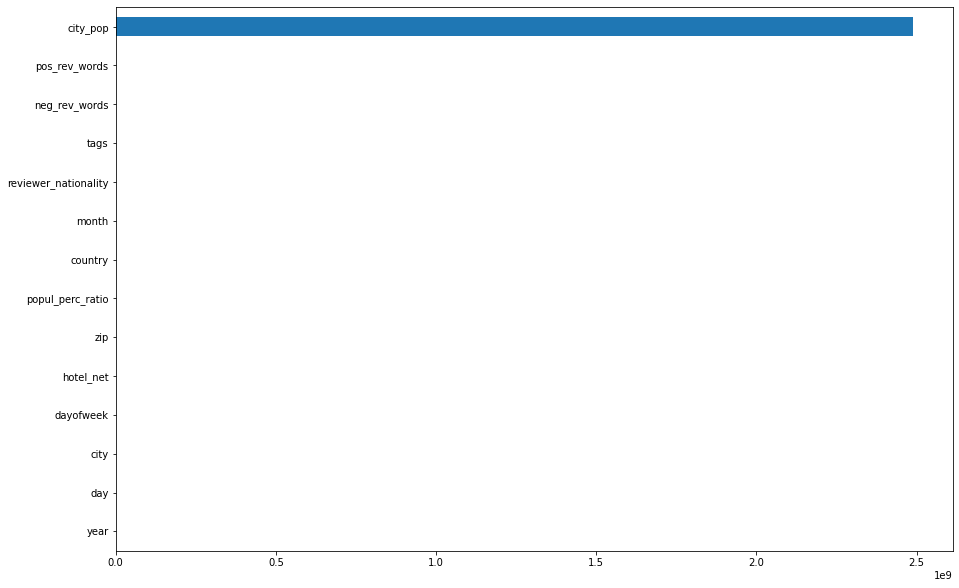

In [51]:
# Влияние категориальных признаков.  
from sklearn.feature_selection import chi2 

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [52]:
# Выбор признаков с рейтингом более 1000.
res_cols = ['reviewer_score']
res_cols.extend(imp_cat[imp_cat >= 100].index)

res_cols

['reviewer_score',
 'hotel_net',
 'zip',
 'popul_perc_ratio',
 'country',
 'month',
 'reviewer_nationality',
 'tags',
 'neg_rev_words',
 'pos_rev_words',
 'city_pop']

<AxesSubplot:>

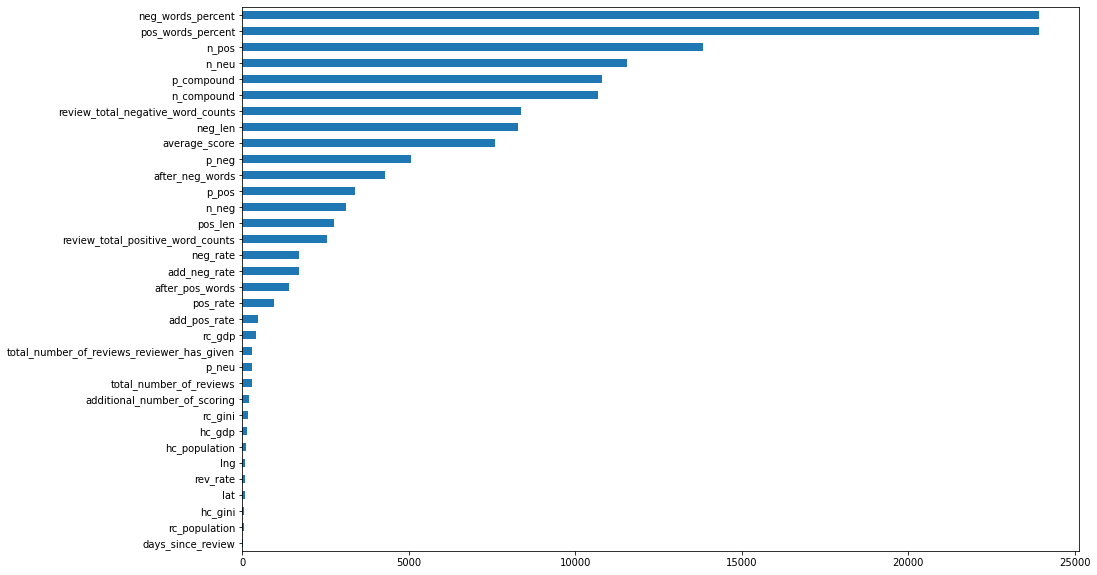

In [53]:
from sklearn.feature_selection import f_classif 

# Влияние числовых признаков.  
plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [54]:
# Выбор числовых признаков с рейтингом более 1000.  
res_cols.extend(imp_num[imp_num > 100].index)
res_cols

['reviewer_score',
 'hotel_net',
 'zip',
 'popul_perc_ratio',
 'country',
 'month',
 'reviewer_nationality',
 'tags',
 'neg_rev_words',
 'pos_rev_words',
 'city_pop',
 'hc_population',
 'hc_gdp',
 'rc_gini',
 'additional_number_of_scoring',
 'total_number_of_reviews',
 'p_neu',
 'total_number_of_reviews_reviewer_has_given',
 'rc_gdp',
 'add_pos_rate',
 'pos_rate',
 'after_pos_words',
 'add_neg_rate',
 'neg_rate',
 'review_total_positive_word_counts',
 'pos_len',
 'n_neg',
 'p_pos',
 'after_neg_words',
 'p_neg',
 'average_score',
 'neg_len',
 'review_total_negative_word_counts',
 'n_compound',
 'p_compound',
 'n_neu',
 'n_pos',
 'pos_words_percent',
 'neg_words_percent']

In [55]:
# Коррекция данных перед обучением модели.  
train_data = train_data[res_cols]
res_cols.remove('reviewer_score')
test_data = test_data[res_cols]

<AxesSubplot:>

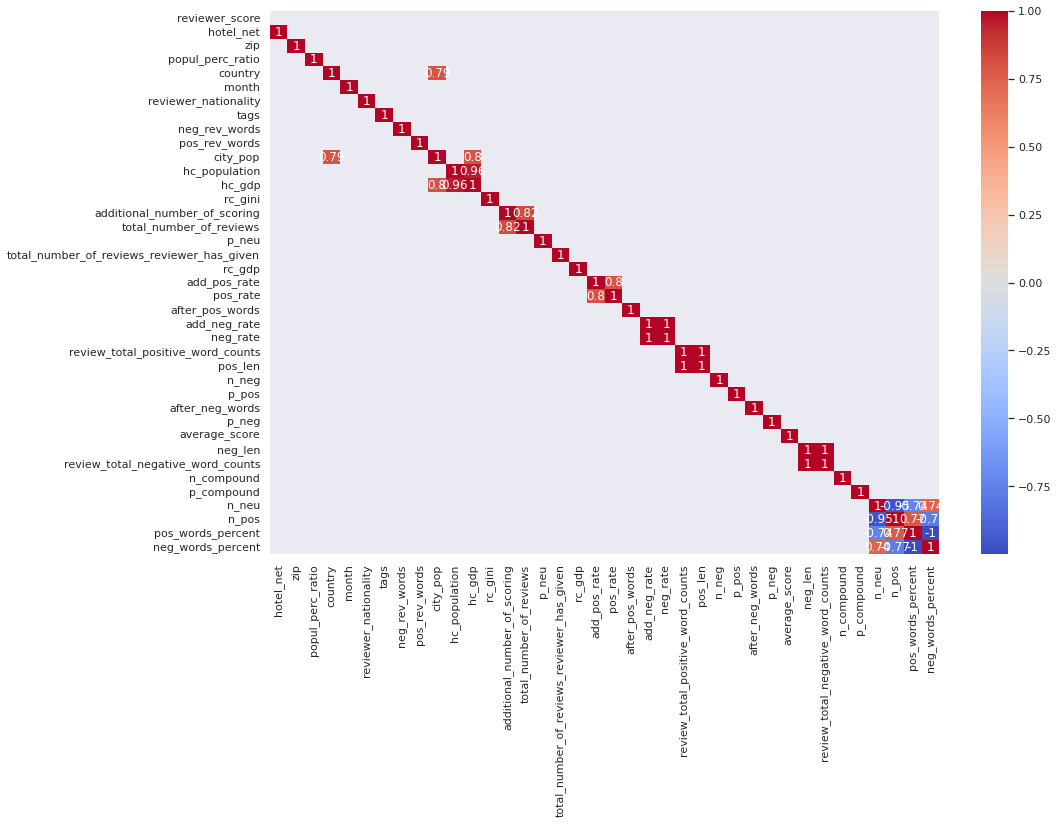

In [56]:
# Корреляция оставшихся признаков.  
corr = train_data.corr()
corr = corr[corr.abs() >= 0.72]
sns.set(rc = {'figure.figsize': (15,10)}) 
sns.heatmap(corr.drop('reviewer_score', axis=1), annot=True, \
    annot_kws={'fontsize': 12}, cmap='coolwarm') 

In [57]:
# Устранение мультиколлинеарности.
drop_col = ['hc_gdp', 'additional_number_of_scoring', 'add_pos_rate', \
            'add_neg_rate', 'pos_len', 'neg_len', 'neg_words_percent', \
            'pos_words_percent', 'n_neu', 'country']

train_data.drop(drop_col,axis=1,inplace=True)
test_data.drop(drop_col,axis=1,inplace=True)

<AxesSubplot:>

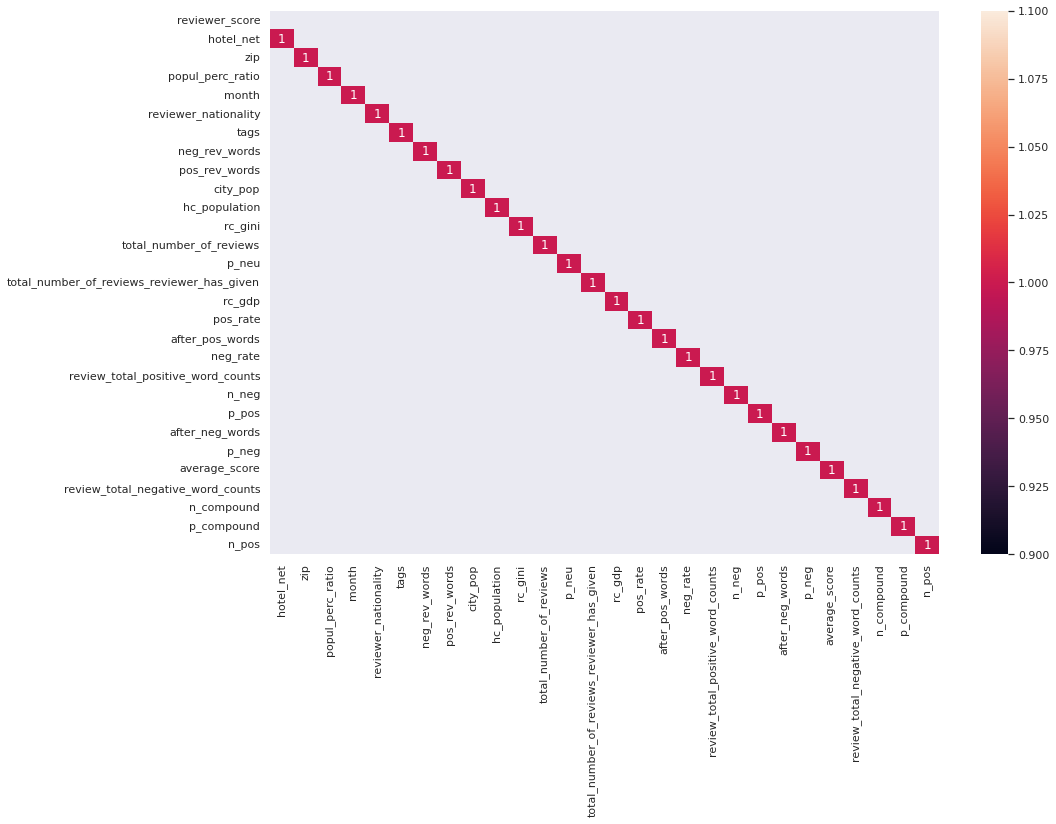

In [58]:
# Корреляция после устранения сильной связи.  
corr = train_data.corr()
corr = corr[corr.abs() >= 0.72]
sns.set(rc = {'figure.figsize': (15,10)}) 
sns.heatmap(corr.drop('reviewer_score', axis=1), annot=True, \
    annot_kws={'fontsize': 12}) 

<font color='green'>

# **Подготовка и тренировка модели.**</font>

In [59]:
# Выделение тестовой части.
y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [60]:
# Разделение тренингового датасета: 80% на обучение, 20% на валидацию.  
#from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, \
    test_size=0.2, random_state=RANDOM_SEED)

In [61]:
# Размерности=ь получившихся датасетов.  
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 28), (386496, 29), (386496, 28), (309196, 28), (77300, 28))

In [62]:
# Импортирование необходимых библиотек.
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, \
    random_state=RANDOM_SEED)

In [63]:
%%time
# Обучение модели.  
model.fit(X_train, y_train)

# Предсказание обученной моделью рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываются в переменную y_pred.  
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s


CPU times: user 12min 31s, sys: 2.61 s, total: 12min 34s
Wall time: 3min 13s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [64]:
# Функция Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
# Сравнение предсказанных значений (y_pred) с реальными (y_test).
# Насколько они в среднем отличаются.
# Метрика называется Mean Absolute Error (MAE) и показывает 
# среднее отклонение предсказанных значений от фактических.  
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8528682189367335
MAPE: 12.16458017499237


<AxesSubplot:>

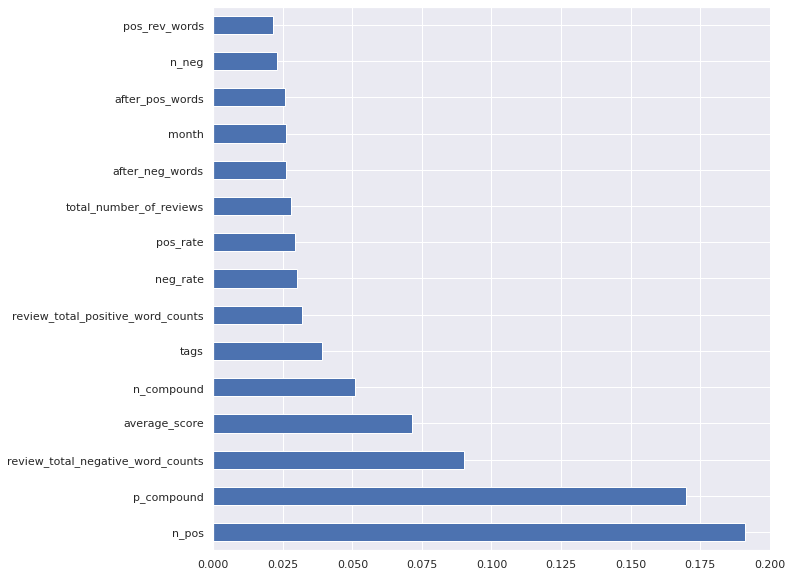

In [66]:
# Вывод самых важных признаков для модели.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [67]:
test_data.sample(10)
predict_submission = model.predict(test_data)
predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


array([8.704, 7.685, 8.377, ..., 8.141, 9.331, 6.887])

In [68]:
display(len(predict_submission))
display(len(sample_submission))
sample_submission['id']

128935

128935

0         488440
1         274649
2         374688
3         404352
4         451596
           ...  
128930    495812
128931    315577
128932    511968
128933    303386
128934    103157
Name: id, Length: 128935, dtype: int64

In [69]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('nsd_submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.704  488440
1           7.685  274649
2           8.377  374688
3           9.784  404352
4           9.619  451596
5           8.974  302161
6           7.823  317079
7           7.660   13963
8           8.658  159785
9           7.781  195089